In [ ]:
from google.colab import drive
import cv2
import os
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

In [ ]:
#drive.mount('/content/drive',force_remount=True)

In [ ]:
img=[]
i=cv2.imread('/content/H01.bmp')
img.append(cv2.cvtColor(i, cv2.COLOR_BGR2GRAY))
i=cv2.imread('/content/H02.bmp')
img.append(cv2.cvtColor(i, cv2.COLOR_BGR2GRAY))
i=cv2.imread('/content/H03.bmp')
img.append(cv2.cvtColor(i, cv2.COLOR_BGR2GRAY))
i=cv2.imread('/content/H04.bmp')
img.append(cv2.cvtColor(i, cv2.COLOR_BGR2GRAY))
i=cv2.imread('/content/H05.bmp')
img.append(cv2.cvtColor(i, cv2.COLOR_BGR2GRAY))
imgGT=[]
i=cv2.imread('/content/H01.tiff')
imgGT.append(cv2.cvtColor(i, cv2.COLOR_BGR2GRAY))
i=cv2.imread('/content/H02.tiff')
imgGT.append(cv2.cvtColor(i, cv2.COLOR_BGR2GRAY))
i=cv2.imread('/content/H03.tiff')
imgGT.append(cv2.cvtColor(i, cv2.COLOR_BGR2GRAY))
i=cv2.imread('/content/H04.tiff')
imgGT.append(cv2.cvtColor(i, cv2.COLOR_BGR2GRAY))
i=cv2.imread('/content/H05.tiff')
imgGT.append(cv2.cvtColor(i, cv2.COLOR_BGR2GRAY))
print(len(img))
print(len(imgGT))

5
5


In [ ]:

kernel=np.zeros((3,3))

std_array=[]

# Traversing through all the images
for test_img in img:

  #Adding padding to image
  test_img=np.pad(test_img,1, 'symmetric')

  #Initializing a Matrix for local standard deviation
  std=np.zeros((test_img.shape[0],test_img.shape[1]))
  for j in range(1,test_img.shape[0]-1):
    for k in range(1,test_img.shape[1]-1):

      # Local window of size 3x3
      kernel=test_img[j-1:j+2][:,k-1:k+2]

      #calculting standard deviation on 3x3 window
      s=np.std(kernel)

      #calculting mean on 3x3 window
      m=np.mean(kernel)


      #Normalize the standard deviation
      std[j][k]=int(s*2)/(m+1)
      #print(std[j][k])
  std=std[1:test_img.shape[0]-1,1:test_img.shape[1]-1]
  std_array.append(std)

In [ ]:
resultimg_array=[]
nmin=0
nmax=1
i=0
for stdarr in std_array:

  #Chaning the range of std values for calculation purposes only
  stdarr2=stdarr*100

  #Taking mean of all the values in local standard deviation array
  # zero values are omitted before taking the mean
  std_mean=np.mean(stdarr2[np.nonzero(stdarr2)])
  print(std_mean)

  #Applying OTSU thresholding
  dis,otsu_img = cv2.threshold(stdarr2.astype(img[i].dtype), 0, 1, cv2.THRESH_OTSU)
  resultimg_array.append(otsu_img)
  i+=1

3.706387607284946
8.643594024028065
6.914453313860619
7.743396113967001
3.784803151791026


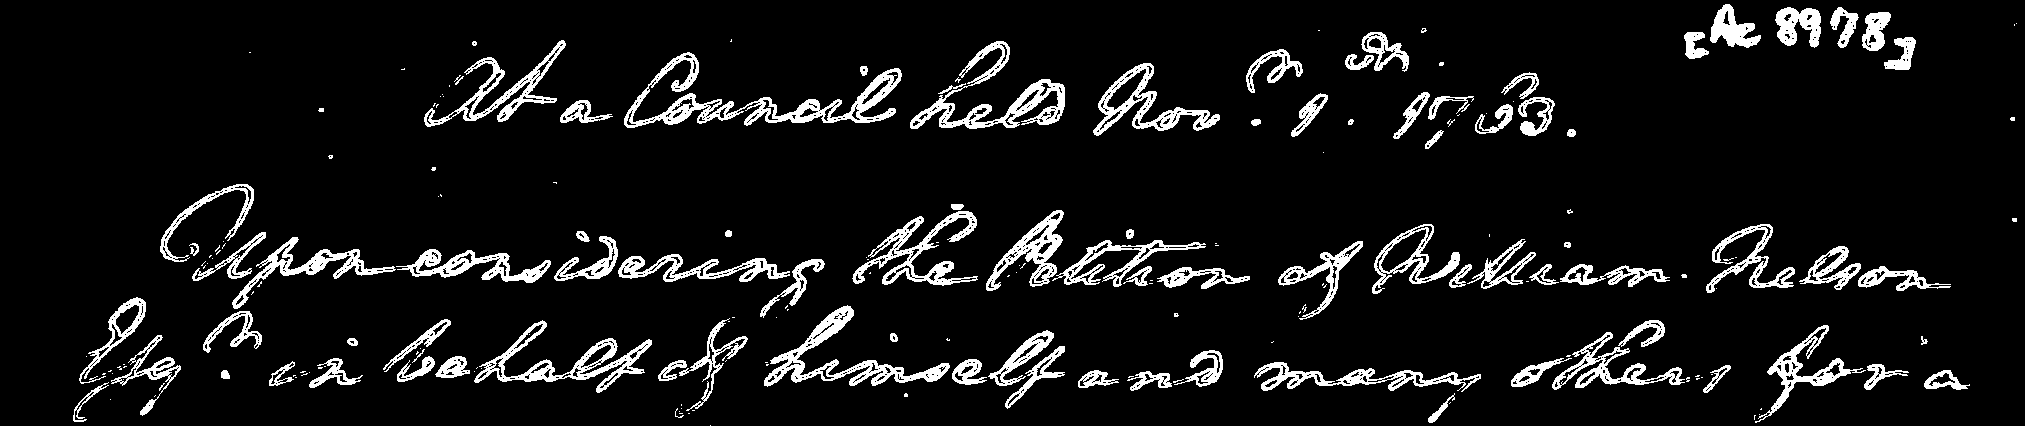

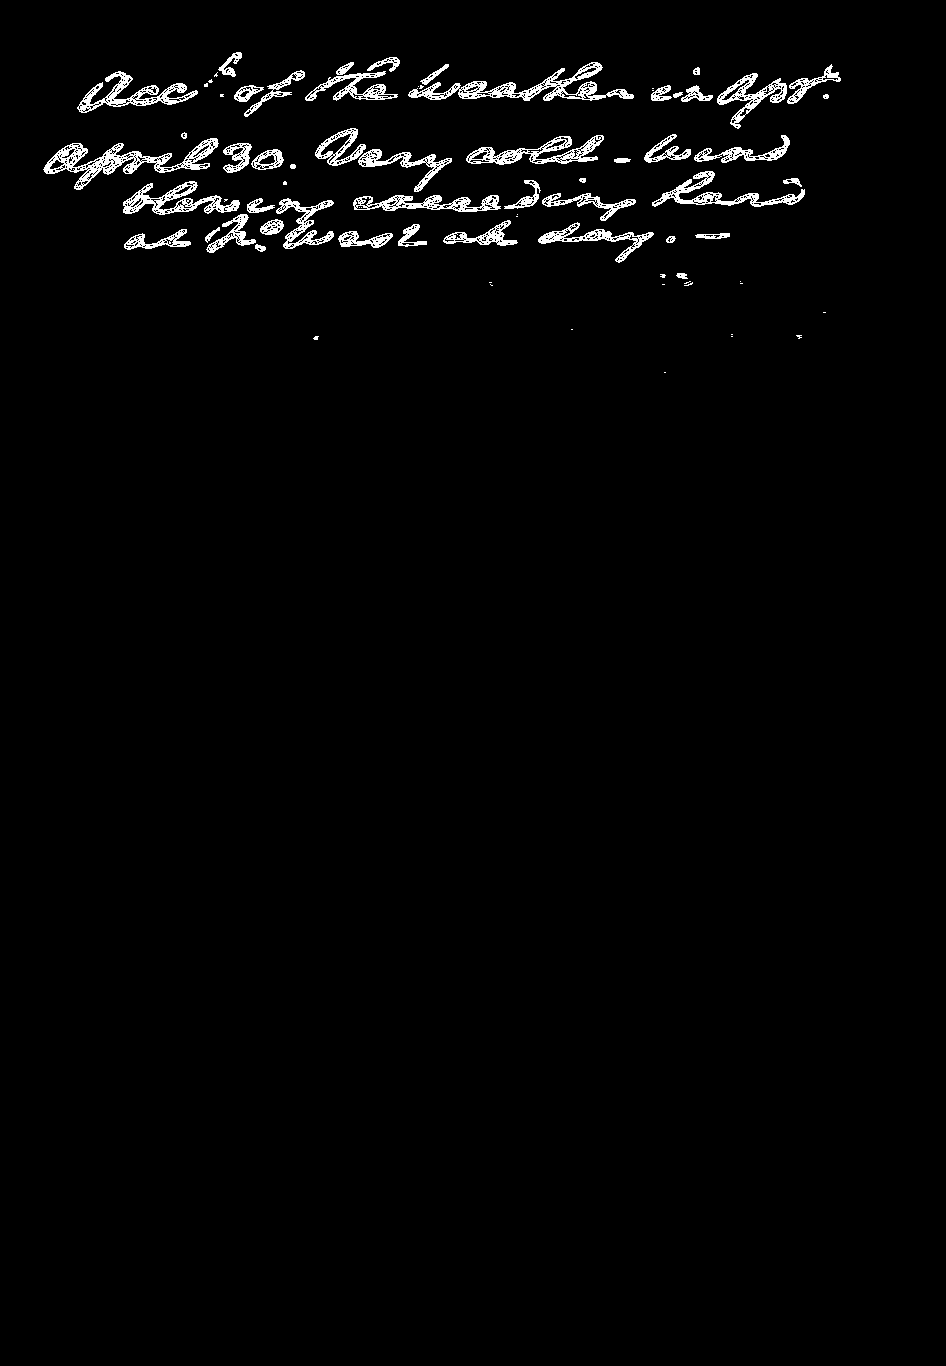

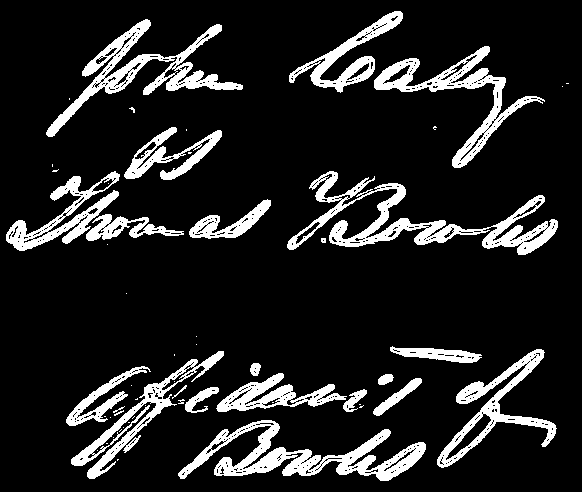

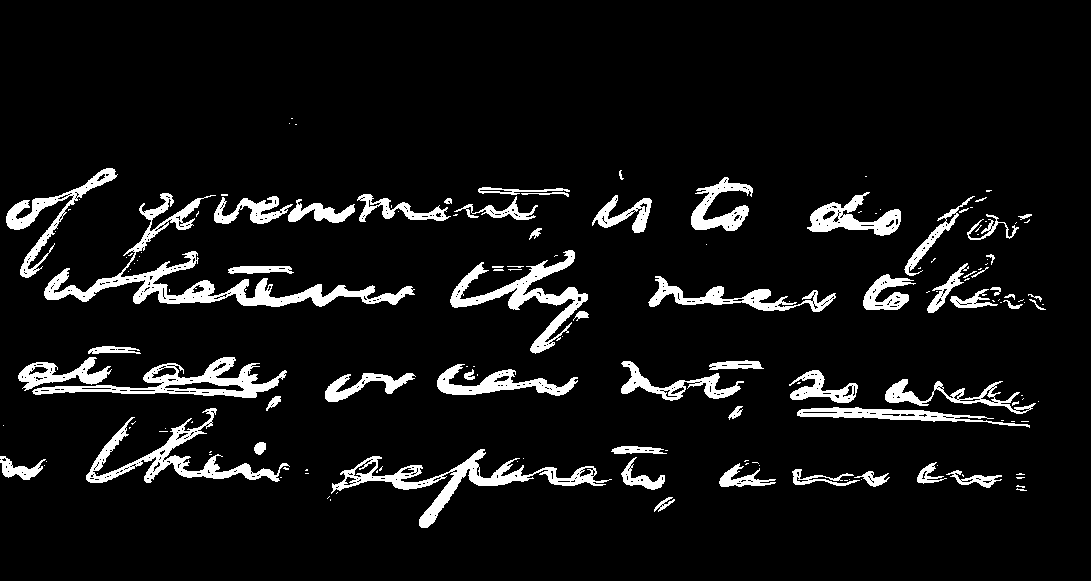

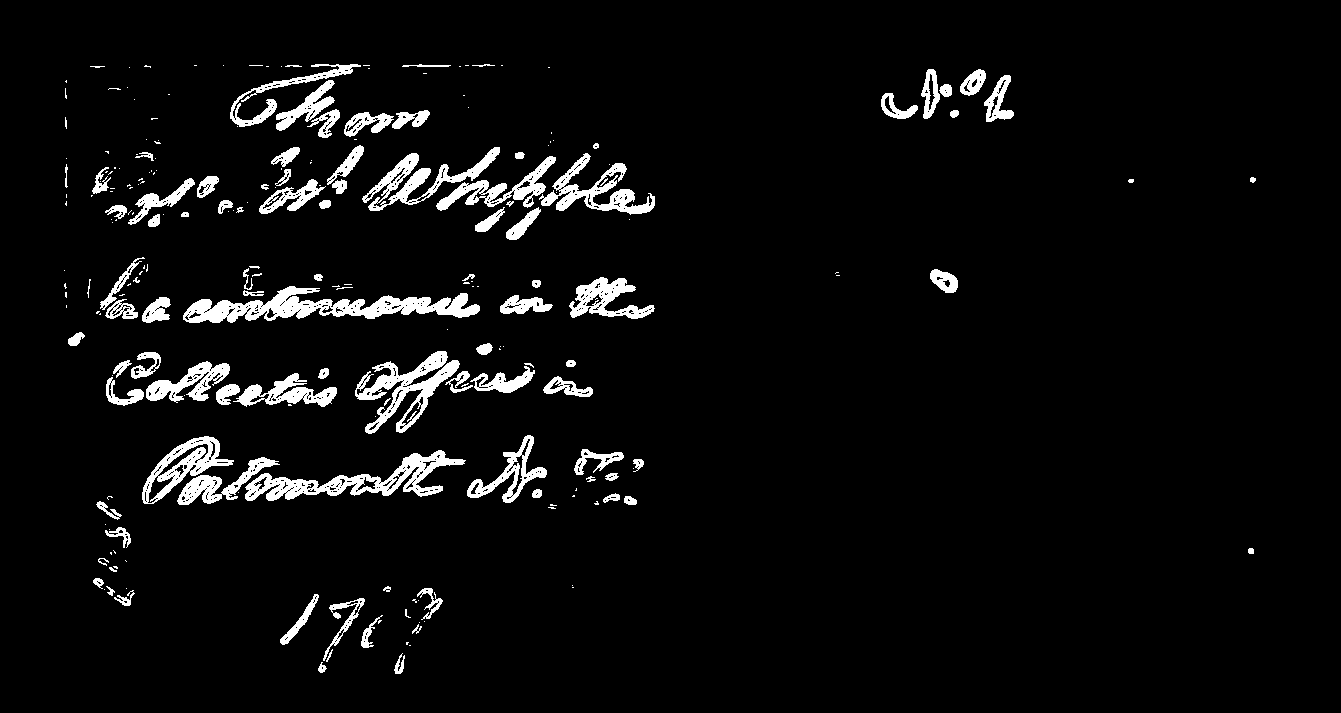

In [ ]:
for resultimg in resultimg_array:
  cv2_imshow(resultimg*255)

In [ ]:
kernel1=np.zeros((7,7))
final_array=[]
i=0


for test_img in img:
  final=np.zeros((resultimg_array[i].shape[0],resultimg_array[i].shape[1]))
  # Using image obtained by otsu thresholding
  for j in range(2,resultimg_array[i].shape[0]-1):
      for k in range(2,resultimg_array[i].shape[1]-1):

        #Creating a 7x7 window on image obtained from OTSU thresholding
        resultimg_kernel=resultimg_array[i][j-3:j+4][:,k-3:k+4]

        #Creating a 7x7 window original image
        kernel1=test_img[j-3:j+4][:,k-3:k+4]

        #mutliplying both the windows
        avg_kernel=kernel1*resultimg_kernel


        non_zero_avg_kernel=avg_kernel[np.nonzero(avg_kernel)]
        avg=np.mean(non_zero_avg_kernel)
        stdev=np.std(non_zero_avg_kernel)
        #print('img: ',test_img[j][k],'avg: ',avg)

        #Creating a binary file
        #checking the neighboring pixels and value of the original image
        if(np.count_nonzero(resultimg_kernel == 1)>7 and test_img[j][k]<(avg+stdev/2)):
          final[j][k]=0
        else:
          final[j][k]=1
  final_array.append(final)
  i+=1




/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:

for i in  range(0,len(final_array)):
  final_array[i]=final_array[i][2:final_array[i].shape[0]-2,2:final_array[i].shape[1]-2]
  final_array[i]=np.pad(final_array[i],2, 'constant', constant_values=1)
  final_array[i]=final_array[i]*255



Qualitative Results


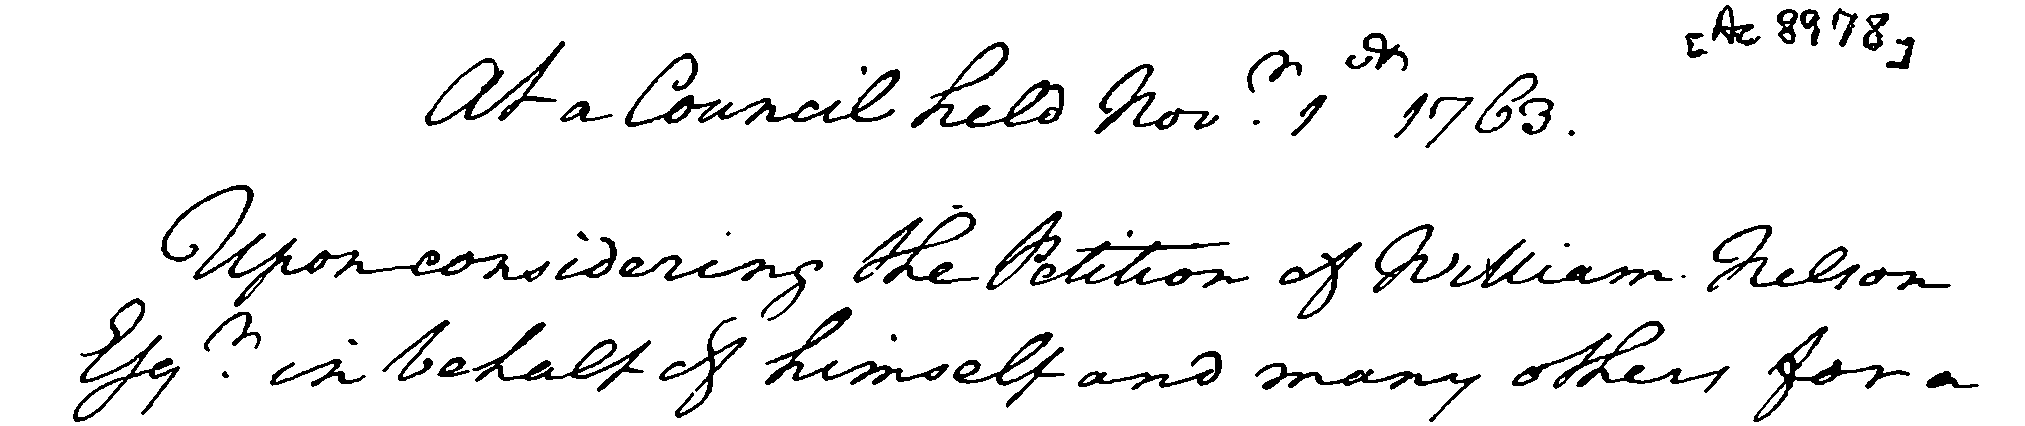

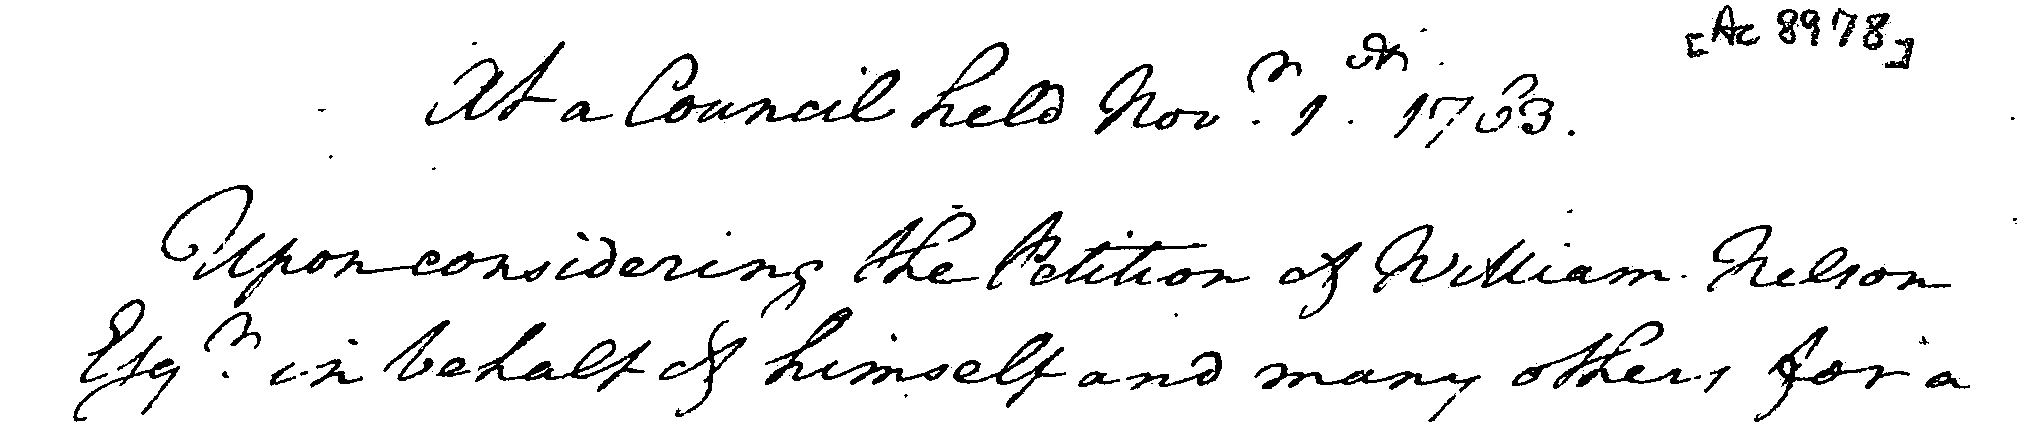

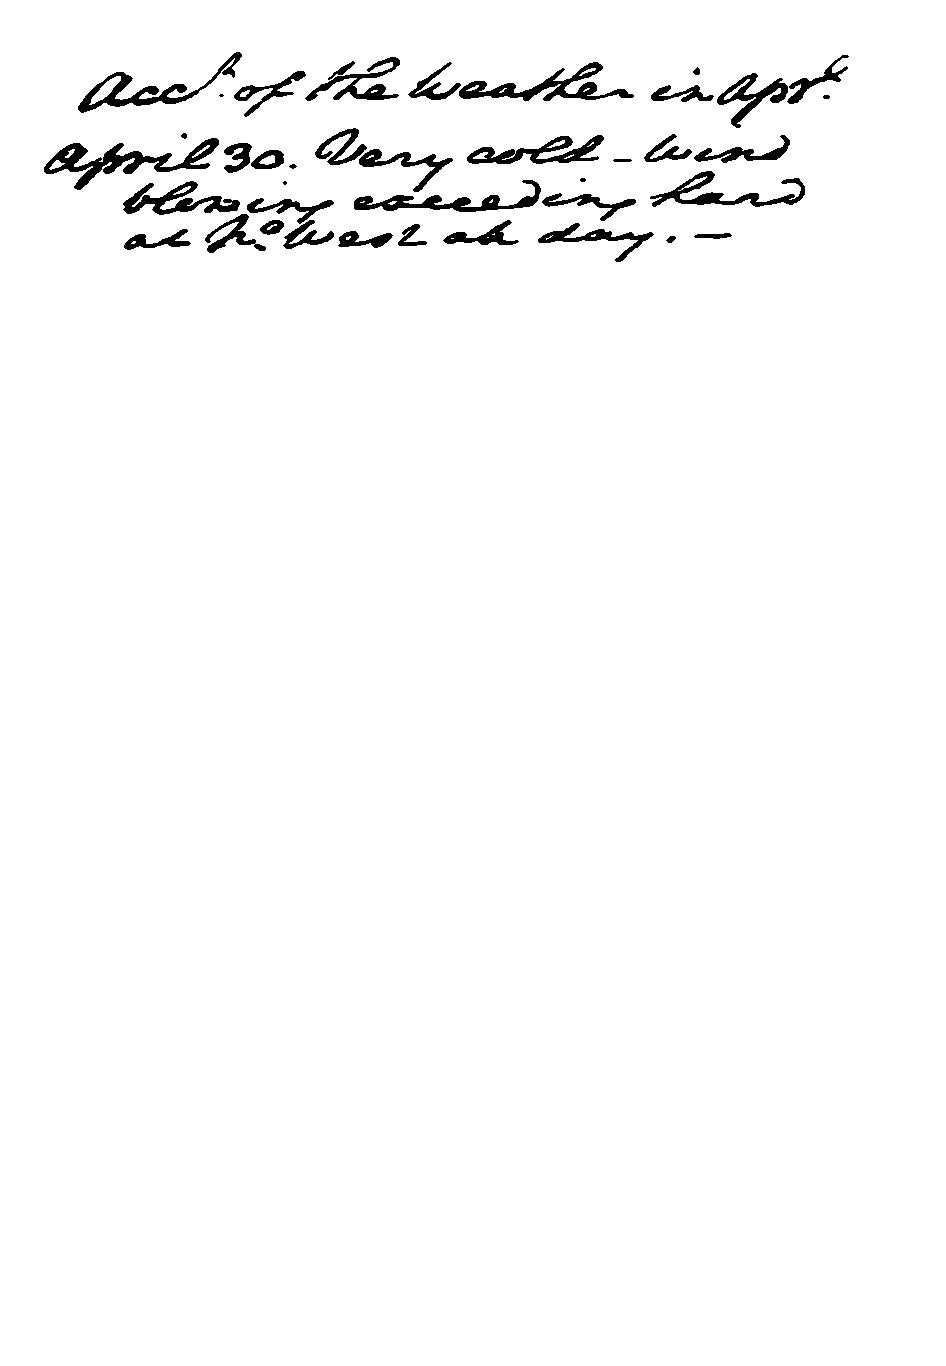

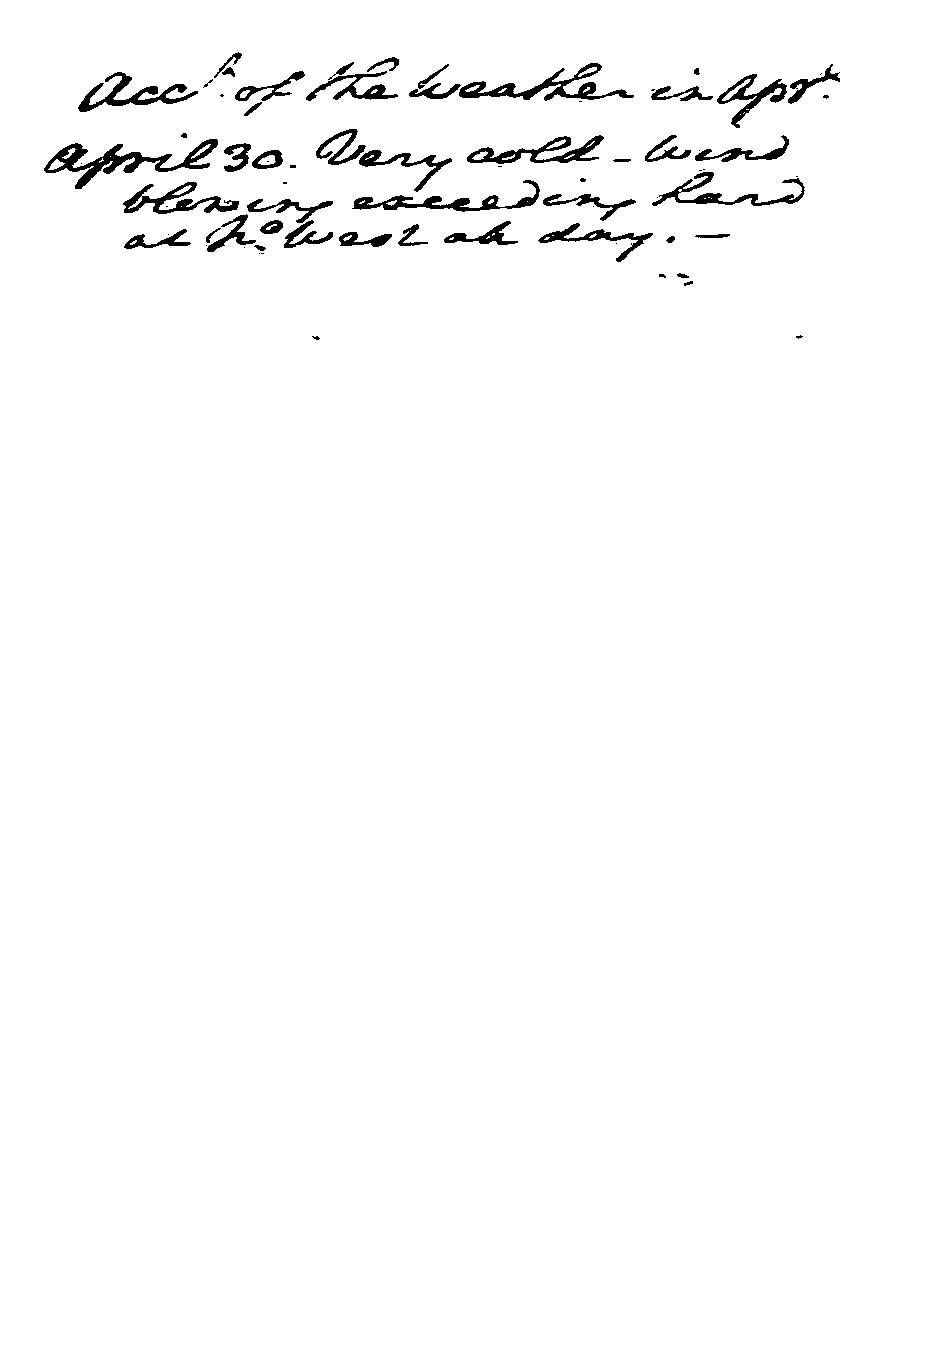

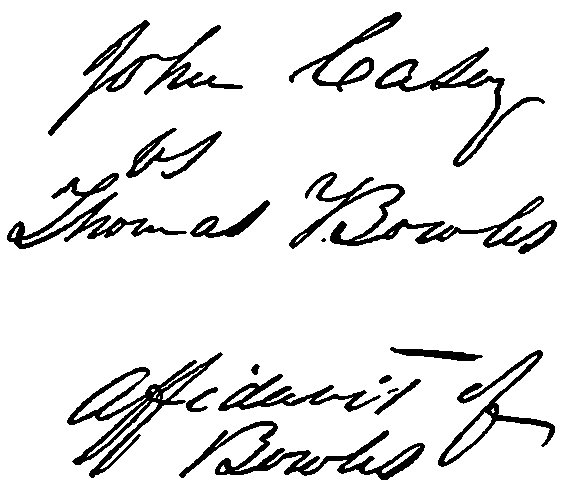

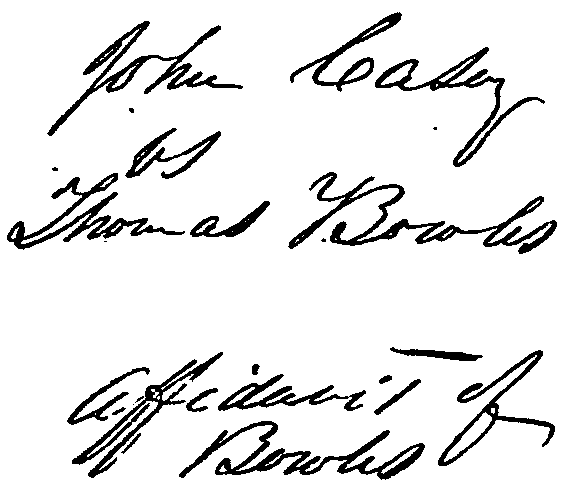

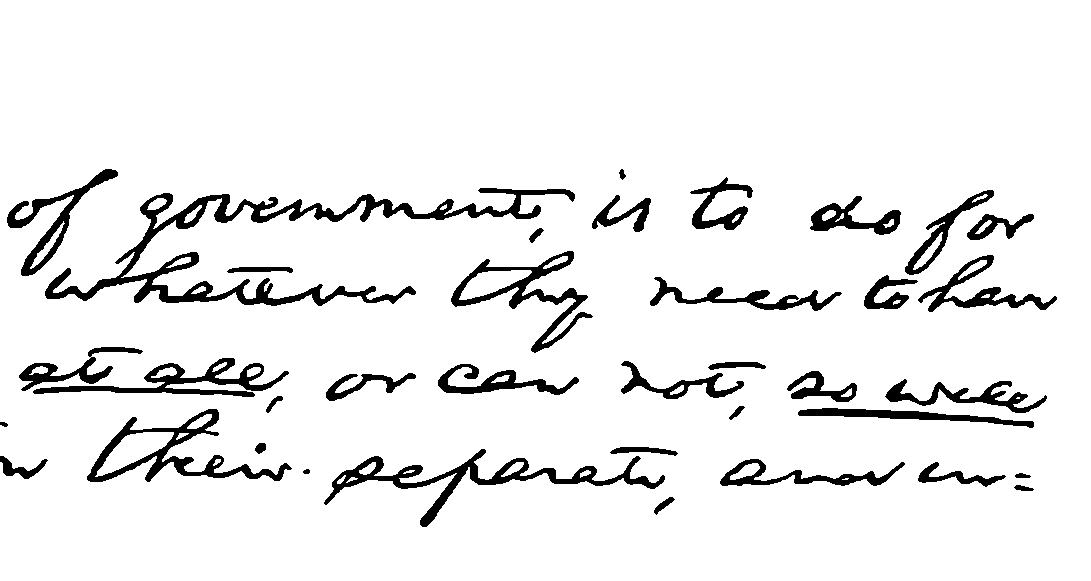

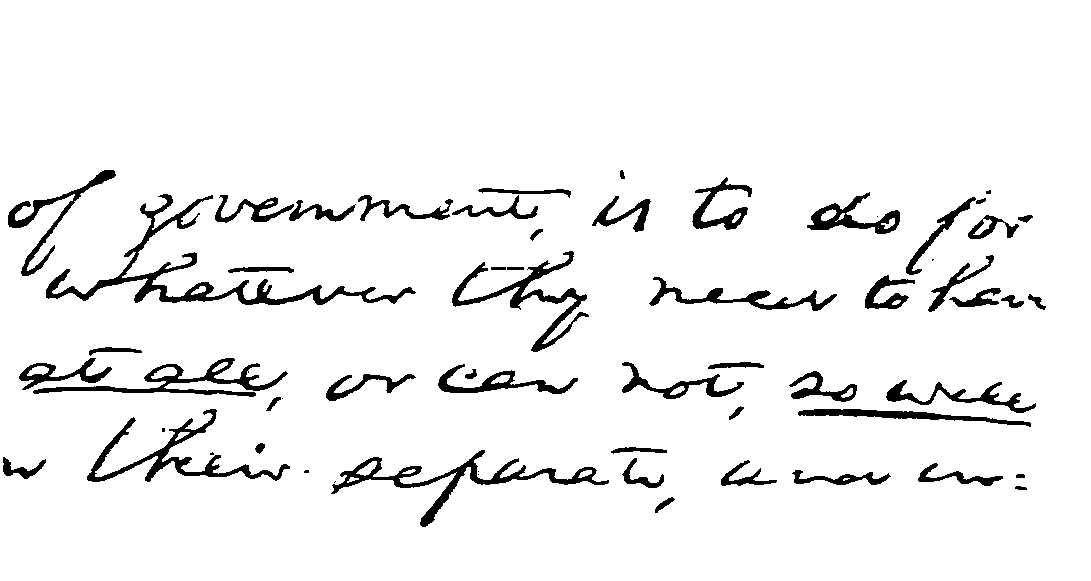

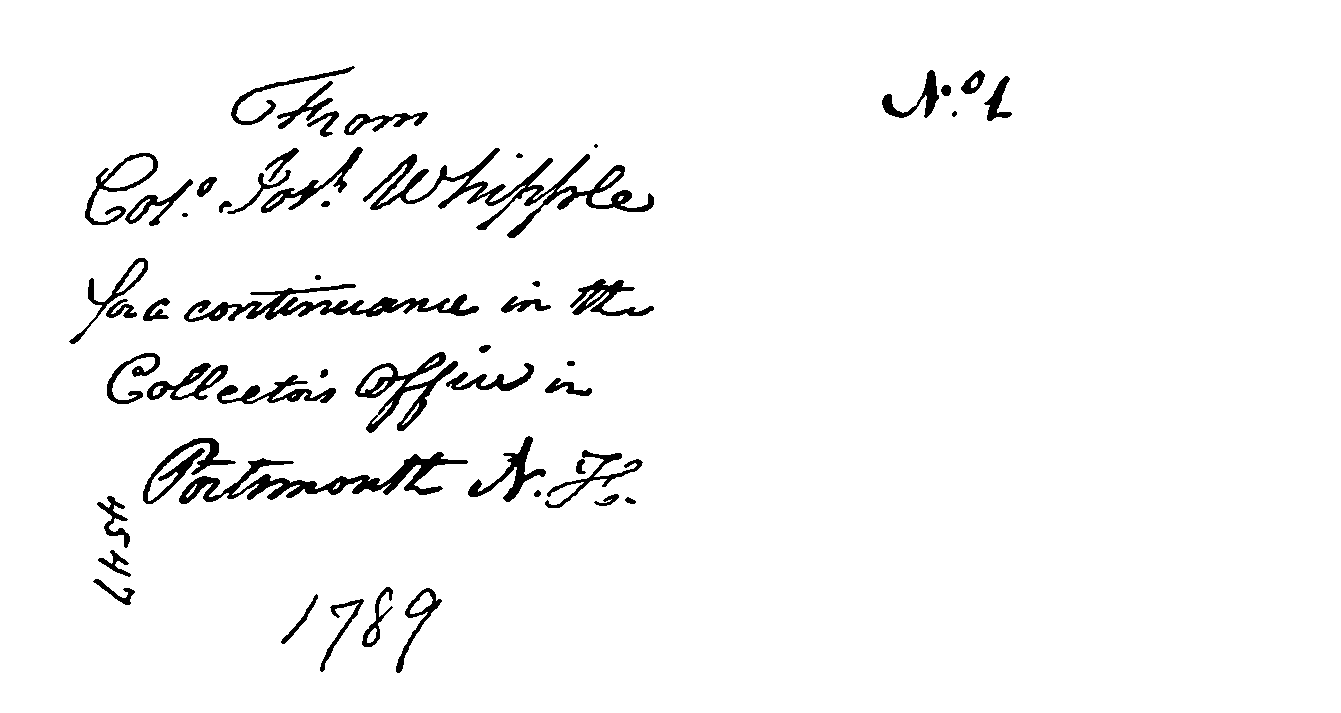

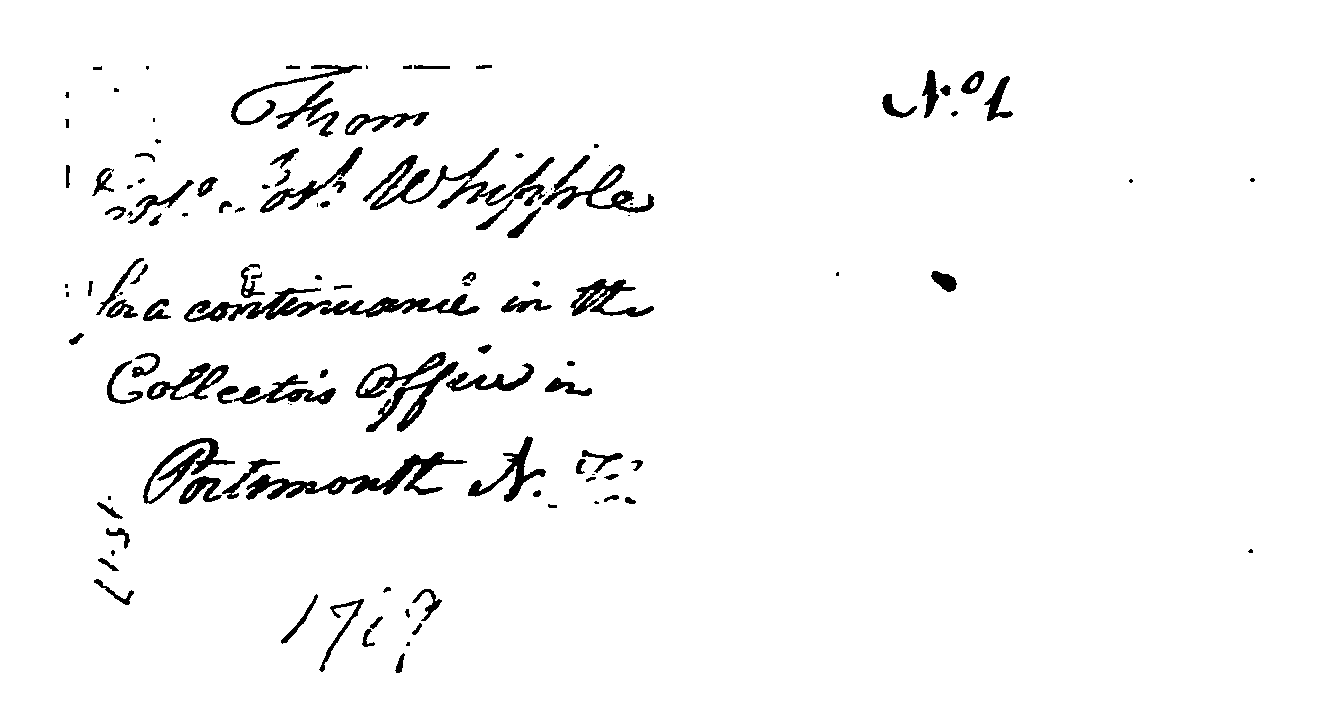

In [ ]:
for i in range(0,len(imgGT)):
  cv2_imshow(imgGT[i])
  cv2_imshow(final_array[i]*255)

Calculating evaluation parameters

In [ ]:
def evaluation(groundT,MyImg):
  TP=0
  TN=0
  FP=0
  FN=0
  for j in range(0,groundT.shape[0]):
    for k in range(0,groundT.shape[1]):
      if(groundT[j][k]==0 and MyImg[j][k]==0):
        TP+=1
      elif(groundT[j][k]==0 and MyImg[j][k]==255):
        FN+=1
      elif(groundT[j][k]==255 and MyImg[j][k]==0):
        FP+=1
      elif(groundT[j][k]==255 and MyImg[j][k]==255):
        TN+=1

  return TP,TN,FP,FN



Quantitative Results

In [ ]:
TFM=[]
PSNR=[]
NRM=[]
for i in range(0,len(imgGT)):
  TP,TN,FP,FN=evaluation(imgGT[i],final_array[i])
  Total=final_array[i].shape[0]*final_array[i].shape[1]
  MSE=np.sum(((imgGT[i]-final_array[i])**2))/Total
  PSNR.append(10*np.log10(((255**2)/MSE)))
  PR=TP/(TP+FP)
  RC=TP/(TP+FN)
  FM=(2*RC*PR)/(RC+PR)
  NRFN=FN/(FN+TP)
  NRFP=FP/(FP+TN)
  NRM.append((NRFP+NRFN)/2)
  print("*********",i,"*********")
  print("TP: ",TP," TN: ",TN," FP: ",FP," FN: ",FN)
  print("Precision: ",PR)
  print("Recall: ",RC)
  print("F Measure: ",FM)
  print("PSNR: ",PSNR[i])
  print("NRM: ",NRM[i])
  TFM.append(FM)
print("///////////////////////////")
print("AVG FM: ",np.mean(TFM))
print("///////////////////////////")
print("AVG PSNR: ",np.mean(PSNR)) # how close the resultant image to the ground truth image
print("///////////////////////////")
print("AVG NRM: ",np.mean(NRM)) # This metric measures pixel mismatch rate between the ground truth image and resultant image.
print("///////////////////////////")

********* 0 *********
TP:  52664  TN:  802375  FP:  2573  FN:  5038
Precision:  0.9534189039955102
Recall:  0.9126893348584104
F Measure:  0.9326096388315815
PSNR:  20.543929047120134
NRM:  0.04525357245709798
********* 1 *********
TP:  23063  TN:  1264008  FP:  272  FN:  4893
Precision:  0.9883436897364474
Recall:  0.8249749606524539
F Measure:  0.899300072137412
PSNR:  23.982715098916675
NRM:  0.0876200907814391
********* 2 *********
TP:  25820  TN:  257259  FP:  1296  FN:  1969
Precision:  0.952205340020652
Recall:  0.9291446255712692
F Measure:  0.940533649030143
PSNR:  19.43004901806156
NRM:  0.03793392379845776
********* 3 *********
TP:  36502  TN:  586934  FP:  439  FN:  9996
Precision:  0.988116185268401
Recall:  0.7850230117424405
F Measure:  0.874938577883244
PSNR:  17.835084295771995
NRM:  0.10786219193239004
********* 4 *********
TP:  31698  TN:  916133  FP:  3546  FN:  4756
Precision:  0.8993871297242084
Recall:  0.8695342074943765
F Measure:  0.8842087645401546
PSNR:  20.